# Section 0: Import Libraries

In [438]:
#Core Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.dates as mdates
from datetime import datetime as dt
from scipy import stats
import os
%matplotlib inline

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


# Section 1: Temperature Analysis I


In [439]:
#Read Measurements.csv
path = os.path.join('..','Resources','hawaii_measurements.csv')
df = pd.read_csv(path)
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  19550 non-null  object 
 1   date     19550 non-null  object 
 2   prcp     18103 non-null  float64
 3   tobs     19550 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 611.1+ KB


In [441]:
# Convert the date column format from string to datetime
df['date']= pd.to_datetime(df['date'])

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   station  19550 non-null  object        
 1   date     19550 non-null  datetime64[ns]
 2   prcp     18103 non-null  float64       
 3   tobs     19550 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 611.1+ KB


In [443]:
df['date'].max()

Timestamp('2017-08-23 00:00:00')

In [444]:
df['date'].min()

Timestamp('2010-01-01 00:00:00')

In [445]:
# Set the date column as the DataFrame index
df.set_index('date',inplace=True)
df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-06,USC00519397,NaN,73


## Compare June and December Data Across All Years

In [446]:
# Filter data for desired months
june = df.loc[df.index.month==6]
december = df.loc[df.index.month==12]

In [447]:
# Identify the average temperature for June
june['tobs'].mean()

74.94411764705882

In [448]:
# Identify the average temperature for December
december['tobs'].mean()

71.04152933421226

In [449]:
# Create collections of temperature data

#Sample for June measurements
g1 = june.sample(n=500, random_state=123)

#Sample for December measurements
g2 = december.sample(n=500, random_state=123)

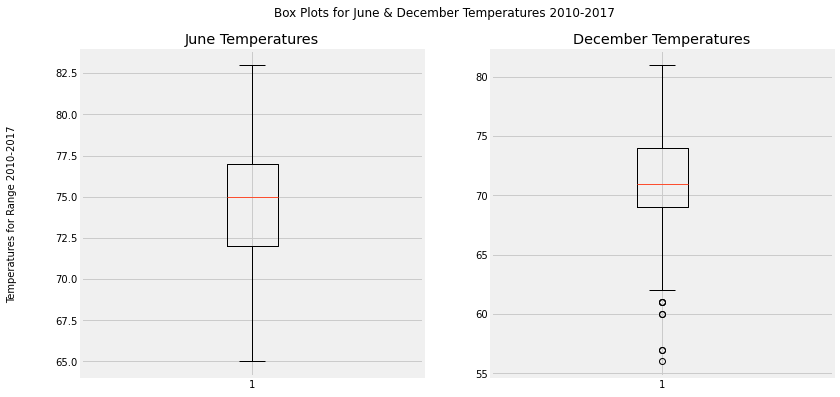

In [450]:
#Ttest for Independent groups
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Box Plots for June & December Temperatures 2010-2017')
ax[0].boxplot(g1['tobs'])
ax[0].title.set_text('June Temperatures')
ax[1].boxplot(g2['tobs'])
ax[1].title.set_text('December Temperatures')
fig.text(0, 0.5, 'Temperatures for Range 2010-2017', ha='center', va='center', rotation ='vertical')
plt.show()

In [451]:
# Calculate Independent (Two Sample) t-test
stats.ttest_rel(g1['tobs'], g2['tobs'])

Ttest_relResult(statistic=17.458039827656215, pvalue=1.275759567469348e-53)

Ho = Hawaii does not have the same weather all year long **meanJune /=/ meanDec**<br>
Ha = Hawaii has the same weather all year long **meanJune = meanDec**

Using a paired 2 sample test, we can reject Ho with a very small p-value, most likely temp in Hawaii remains about the same all year long

# Section 2: Temperature Analysis II

In [452]:
#Create engine for hawaii.sqlite
engine = create_engine('sqlite:///../Resources/hawaii.sqlite')

#Declare Base using automap_base()
Base = automap_base()

#Use the Base to reflect the hawaii.sqlite database
Base.prepare(engine, reflect=True)

In [453]:
#Assign objects for each of the tables

#'measurement' table
Meas = Base.classes.measurement

#'station' table
Stion = Base.classes.station

In [454]:
#Create a session to the hawaii.sqlite
session = Session(engine)

## Calc_Temps Function

In [455]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Meas.tobs), func.round(func.avg(Meas.tobs),2), func.max(Meas.tobs)).\
        filter(Meas.date >= start_date).filter(Meas.date <= end_date).all()

In [456]:
# Selecting dates for the last year starting from the most current record
data = calc_temps('2016-08-23', '2017-08-23')[0]
data

(58.0, 74.59, 87.0)

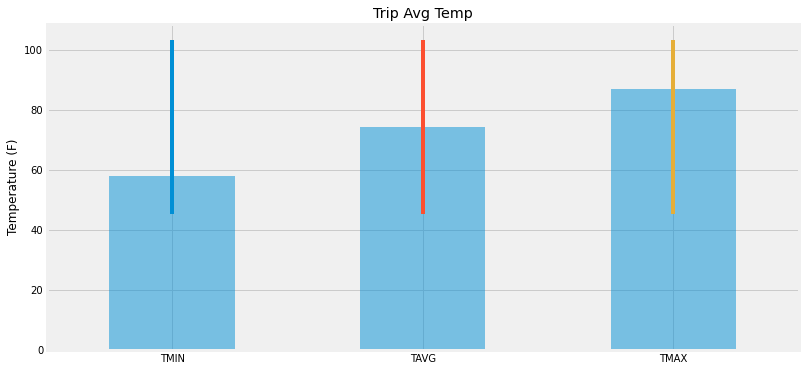

In [457]:
# Ploting  results for selected dates 
df = pd.DataFrame(data)
x_axis = np.arange(len(df))
ax = df.plot(kind='bar', alpha =0.5, align='center',figsize=(12,6), title='Trip Avg Temp', legend=None)
ticks = [v for v in x_axis]
plt.xticks(ticks,['TMIN','TAVG','TMAX'], rotation=0)
ax.set_ylabel('Temperature (F)')
plt.errorbar(x_axis[0],df.iloc[1],yerr=df.iloc[2]-df.iloc[0])
plt.errorbar(x_axis[1],df.iloc[1],yerr=df.iloc[2]-df.iloc[0])
plt.errorbar(x_axis[2],df.iloc[1],yerr=df.iloc[2]-df.iloc[0])
plt.show()

# Daily Rainfall Averge

In [458]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-08-23'
end_date = '2017-08-23'
data = session.query(func.sum(Meas.prcp).label("Total_Prcp"),Stion.station,Stion.name,Stion.latitude,Stion.longitude,Stion.elevation). \
filter(Meas.station==Stion.station).filter(Meas.date>=start_date).filter(Meas.date<=end_date). \
group_by(Stion.station).order_by(func.sum(Meas.prcp).desc()).statement
df = pd.read_sql(data,session.bind)
df

,Total_Prcp,station,name,latitude,longitude,elevation
0,147.81,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,70.03,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,48.51,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,38.01,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,33.24,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,16.09,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,4.59,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [459]:
#Definition of Daily Normals Function
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Meas.date) == date).all()

In [460]:
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start= start_date, end=end_date, freq='d')

# Strip off the year and save a list of strings in the format %m-%d
date_range_n = date_range.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]

for date in date_range_n:
    normals.append(daily_normals(date)[0])

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [461]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame.from_records(normals, columns =['TMIN','TAVG','TMAX'])
df.set_index(date_range, inplace=True)
df

,TMIN,TAVG,TMAX
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


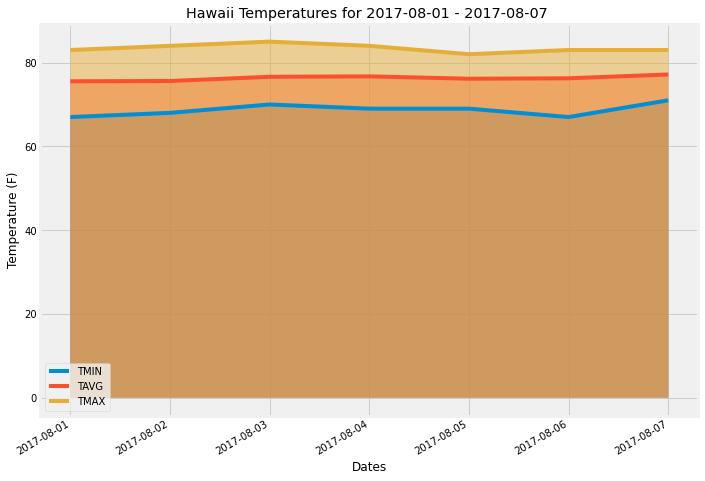

In [463]:
# Plot the daily normals as an area plot with `stacked=False`
ax = plt.gca()
plt.rcParams["figure.figsize"] = (10.5,8)
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)
plt.plot(df.index,df[['TMIN','TAVG','TMAX']])
plt.fill_between(df.index,df['TMIN'], alpha=0.5)
plt.fill_between(df.index,df['TAVG'], alpha=0.5)
plt.fill_between(df.index,df['TMAX'], alpha=0.5)
plt.legend(['TMIN', 'TAVG', 'TMAX'])
plt.title('Hawaii Temperatures for 2017-08-01 - 2017-08-07 ')
plt.xlabel('Dates')
plt.ylabel('Temperature (F)')
plt.gcf().autofmt_xdate()
plt.show()